In [1]:
import csv
import cv2
import numpy as np

lines = []
datafolder = 'drive';
IMGfolder = 'drive/IMG/';
csvP = datafolder + "/driving_log.csv"
with open(csvP) as csvF:
    reader = csv.reader(csvF)
    for line in reader:
        lines.append(line)
        
imgs = []
imgsL = []
imgsR = []
measures = []
def pathNow(path):
    fileName = path.split('/')[-1]
    return IMGfolder + fileName     

for line in lines:
    imgs.append(cv2.imread(pathNow(line[0]), 0))
    imgsL.append(cv2.imread(pathNow(line[1]), 0))
    imgsR.append(cv2.imread(pathNow(line[2]), 0))    
    measures.append(float(line[3]))

sideCameraSteer = 0.1
    
X = np.array(imgs)
XL = np.array(imgsL)
XR = np.array(imgsR)
y = np.array(measures)
yL = np.array(measures) + sideCameraSteer
yR = np.array(measures) - sideCameraSteer

In [2]:
def process(X):
    instance, height, width = X.shape[:3]
    return X[:, int(height*3.5/10): int(height*8/10)]


X_p = process(X)
X_pL = process(XL)
X_pR = process(XR)

X = XL = XR = None

(72, 320) 0.0
(72, 320) 0.0
(72, 320) -0.45


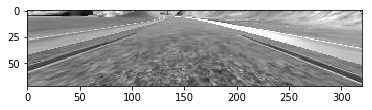

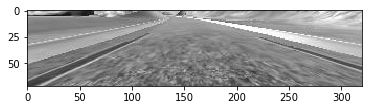

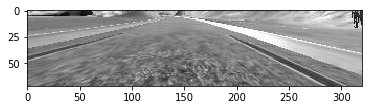

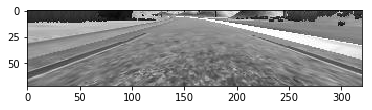

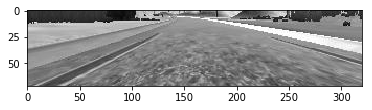

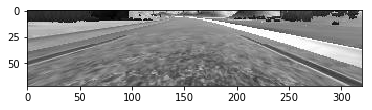

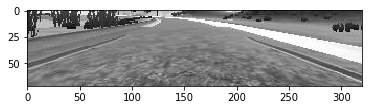

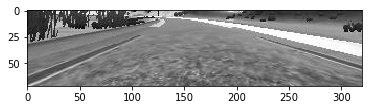

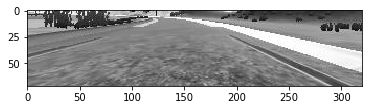

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(3):
    print (X_p[i*100].shape, y[i*100])
    plt.figure()
    plt.imshow(X_p[i*100], 'gray')
    plt.figure()
    plt.imshow(X_pL[i*100], 'gray')
    plt.figure()
    plt.imshow(X_pR[i*100], 'gray')
    

(30864, 72, 320, 1) (30864,)
[-0.45  0.45 -0.35  0.35 -0.55  0.55]


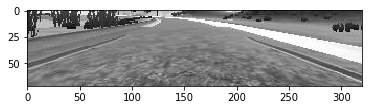

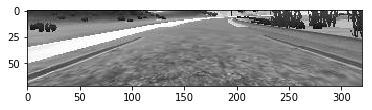

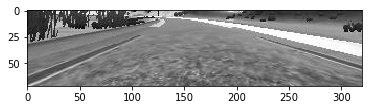

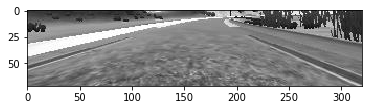

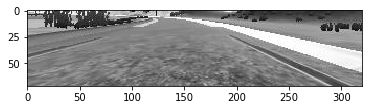

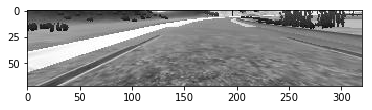

In [4]:
def mirror(x):
    return np.flip(x, 1)

#[x , mx, xl, mxl, ]
X_train = np.concatenate ((X_p, np.flip(X_p, 2),
                            X_pL, np.flip(X_pL, 2),
                            X_pR, np.flip(X_pR, 2),) , 
                            axis = 0)[:,:,:,None]
y_train = np.concatenate ((y, -y,
                            yL, -yL,
                            yR, -yR,), 
                            axis = 0)


print (X_train.shape, y_train.shape)
offset = X_p.shape[0]
testIN = [200, offset+ 200, offset*2+200, offset*3+200, offset*4+200, offset*5+200]

print (y_train[testIN])
for eachX in testIN:
    plt.figure()
    plt.imshow(np.squeeze(X_train[eachX]), 'gray')
    

In [5]:
X_train2 = X_train
y_train2 = y_train

# X_train2 = np.array(X_train[testIN])
# y_train2 = np.array(y_train[testIN])
# X_train2 = np.tile(X_train2, [5,1,1,1])
# y_train2 = np.tile(y_train2, [5])

print (X_train2.shape, y_train2.shape)
print (y_train2)
print (np.mean(np.squeeze(X_train2[0])))


(30864, 72, 320, 1) (30864,)
[ 0.   0.   0.  ...,  0.1  0.1  0.1]
143.956901042


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(72,320,1)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation = 'relu'))
model.add(Convolution2D(64, 3, 3, activation = 'relu'))
model.add(Convolution2D(64, 3, 3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

optimizer = Adam(lr=0.001)
model.compile(loss = 'mse', optimizer =optimizer)
hist = model.fit(X_train2, y_train2, validation_split = 0.2,
          shuffle=True, nb_epoch=5, verbose=1, batch_size = 512)

model.save('model.h5')


Using TensorFlow backend.


Train on 24691 samples, validate on 6173 samples
Epoch 1/10
24691/24691 [==============================] - 382s - loss: 0.0714 - val_loss: 0.0708
Epoch 2/10
24691/24691 [==============================] - 365s - loss: 0.0580 - val_loss: 0.0557
Epoch 3/10
24691/24691 [==============================] - 366s - loss: 0.0496 - val_loss: 0.0529
Epoch 4/10
24691/24691 [==============================] - 366s - loss: 0.0449 - val_loss: 0.0486
Epoch 5/10
24691/24691 [==============================] - 367s - loss: 0.0394 - val_loss: 0.0491
Epoch 6/10
24691/24691 [==============================] - 367s - loss: 0.0363 - val_loss: 0.0449
Epoch 7/10
24691/24691 [==============================] - 367s - loss: 0.0326 - val_loss: 0.0435
Epoch 8/10
24691/24691 [==============================] - 367s - loss: 0.0294 - val_loss: 0.0402
Epoch 9/10
24691/24691 [==============================] - 367s - loss: 0.0273 - val_loss: 0.0397
Epoch 10/10
24691/24691 [==============================] - 369s - loss: 0.0256

In [9]:
print (model.predict(X_train[testIN]))
print (y_train[testIN])


[[-0.09177122]
 [ 0.09827404]
 [ 0.00451863]
 [ 0.02789798]
 [-0.19667482]
 [ 0.25393459]]
[-0.45  0.45 -0.35  0.35 -0.55  0.55]


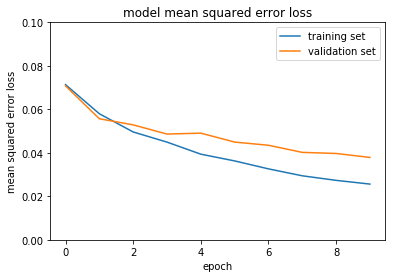

In [8]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.ylim([0,0.1])
plt.show()